# Imports de bibliotecas necessárias

In [215]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

In [236]:
# Definir los directorios y variables estaticas
root_dir = 'png-dataset'
train_dir = 'png-train-dataset'
val_dir = 'png-val-dataset'

# Definir el tamaño de la imagen
img_size = 128

# configurar el tamaño de los hiperparametros de los batch
batch_size = 32

In [25]:
# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datos de entrenamiento y validación
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# convertir los datos a iterables (batches)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Imprimir el tamaño de los datasets
print(f"DataLoaders: {train_loader, val_loader}")
print(f"longitud de train_loader: {len(train_loader)} batches de {batch_size} = {len(train_loader)*batch_size} imágenes")
print(f"longitud de train_loader: {len(val_loader)} batches de {batch_size} = {len(val_loader)*batch_size} imágenes")

# comprobamos el interior de los datos de entrenamiento en el Data Loader
train_feature_batch, train_labels_batch = next(iter(train_loader))
train_feature_batch.shape, train_labels_batch.shape

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001CE716E1B80>, <torch.utils.data.dataloader.DataLoader object at 0x000001CE716A0AD0>)
longitud de train_loader: 2093 batches de 32 = 66976 imágenes
longitud de train_loader: 524 batches de 32 = 16768 imágenes


(torch.Size([32, 3, 128, 128]), torch.Size([32]))

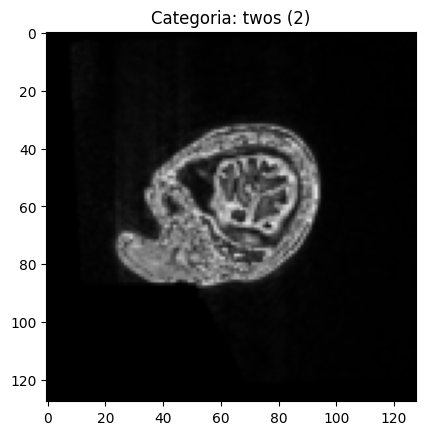

In [216]:
def show_image(img, label):
    # Desnormalizar la imagen
    img = img * 0.5 + 0.5  # Deshace la normalización
    img = img.permute(1, 2, 0)  # Reorganizar las dimensiones para imshow
    img = img.numpy()  # Convertir a numpy
    
    plt.imshow(img)
    plt.title(f"Categoria: {train_dataset.classes[label]} ({label})")
    plt.show()

# Mostrar una imagen de ejemplo normalizada
img, label = train_dataset[60000]
show_image(img, label)



# Funciones utiles para el uso de GPU

In [27]:
def get_default_device():
    #Escoge la GPU si está disponible, de lo contrario la CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Mueve los tensores a la GPU
    if isinstance(data, (list, tuple)):
        return [to_device(x, device)for x in data]
    return data.to(device, non_blocking=True)

def set_gpu_memory_usage(percentage):
    torch.cuda.empty_cache()
    torch.cuda.set_per_process_memory_fraction(percentage)

class DeviceDataLoader():
    #Envuelve un DataLoader para mover los datos a un dispositivo
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    #Itera sobre los batches del DataLoader
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    #Devuelve el número de batches
    def __len__(self):
        return len(self.dl)
    

In [28]:
device = get_default_device()
set_gpu_memory_usage(0.5) # Limitar el uso de la memoria de la GPU al 50%
device

device(type='cuda')

# Modelo CNN 2D

In [29]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [30]:
# Funciones de utilidad para entrenar el modelo
class CustomCNNBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generar predicciones
        loss = F.cross_entropy(out, labels) # Calcular la pérdida
        acc = accuracy(out, labels)         # Calcular la precisión
        return loss, acc

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina las pérdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina las precisiones
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
            
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generar predicciones
        loss = F.cross_entropy(out, labels)   # Calcular la pérdida
        acc = accuracy(out, labels)           # Calcular la precisión
        return {'val_loss': loss.detach(), 'val_acc': acc}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
# Revisamos el tamaño de las imágenes
for images, labels in train_dataset:
    print('images shape is: ', images.shape)
    break

images shape is:  torch.Size([3, 128, 128])


In [32]:
# Definir la arquitectura del modelo

class v0_128_Tiny_Custom2DCNN(CustomCNNBase):
    def __init__(self):
        super(v0_128_Tiny_Custom2DCNN, self).__init__()
        #Imagen de entrada: 3 x 128 x 128

        # Primera capa convolucional (Entrada: 3 x 128 x 128, Salida: 8 x 128 x 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)

        # Segunda capa convolucional (Entrada: 8 x 128 x 128, Salida: 16 x 128 x 128)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        # Capa completamente conectada 1 (entrada: 16 x  128 x 128, salida: 3)
        self.fc1 = nn.Linear(16 * 128 * 128, 3)


    def forward(self, x):
        # Aplicar primera capa convolucional
        x = F.relu(self.conv1(x))
        # Aplicar segunda capa convolucional
        x = F.relu(self.conv2(x))

        # Flatten
        x = self.flatten(x)
        # Aplicar primera capa completamente conectada
        x = self.fc1(x)
        return x

In [33]:
# Instanciamos el modelo y lo enviamos al dispositivo cuda o cpu
model = v0_128_Tiny_Custom2DCNN()
model.to(device)

v0_128_Tiny_Custom2DCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=262144, out_features=3, bias=True)
)

In [237]:
summary(model,input_size=(3 , img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
            Conv2d-2         [-1, 16, 128, 128]           1,168
           Flatten-3               [-1, 262144]               0
            Linear-4                    [-1, 3]         786,435
Total params: 787,827
Trainable params: 787,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.00
Params size (MB): 3.01
Estimated Total Size (MB): 8.19
----------------------------------------------------------------


# Funcion para evaluar y entrenar

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase de entrenamiento
        model.train()
        train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            loss, acc = model.training_step(batch)           
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Fase de validación
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0009

In [38]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.7342, val_loss: 0.4522, val_acc: 0.7963
Epoch [1], train_loss: 0.4113, val_loss: 0.4178, val_acc: 0.8169
Epoch [2], train_loss: 0.3243, val_loss: 0.4667, val_acc: 0.7780
Epoch [3], train_loss: 0.2669, val_loss: 0.5049, val_acc: 0.7900
Epoch [4], train_loss: 0.2400, val_loss: 0.5386, val_acc: 0.7980
Epoch [5], train_loss: 0.2165, val_loss: 0.5095, val_acc: 0.8053
Epoch [6], train_loss: 0.1997, val_loss: 0.5509, val_acc: 0.8092
Epoch [7], train_loss: 0.1900, val_loss: 0.5605, val_acc: 0.8185
Epoch [8], train_loss: 0.1768, val_loss: 0.6421, val_acc: 0.8115
Epoch [9], train_loss: 0.1746, val_loss: 0.6412, val_acc: 0.8098
Epoch [10], train_loss: 0.1632, val_loss: 0.7472, val_acc: 0.8026
Epoch [11], train_loss: 0.1585, val_loss: 0.7139, val_acc: 0.8157
Epoch [12], train_loss: 0.1534, val_loss: 0.8616, val_acc: 0.8125
Epoch [13], train_loss: 0.1481, val_loss: 0.8034, val_acc: 0.8139
Epoch [14], train_loss: 0.1450, val_loss: 0.8207, val_acc: 0.8191
Epoch [15], train_lo

# Evaluación del modelo

In [ ]:
# Obtener las predicciones para el conjunto de validación
model.eval()
y_true = []
y_pred = []

for images, labels in val_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true += labels.cpu()
    y_pred += preds.cpu()

In [73]:
# Precision vs Epoch y Perdida vs Epoch
def plot_accuracies(history):
    # Ajustar el tamaño de la figura
    plt.figure(figsize=(12, 6))  # Ancho: 12 pulgadas, Altura: 6 pulgadas

    # Gráfico de precisión
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Precisión')
    plt.title('Precisión vs. Epoch')

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Perdida')
    plt.legend(['Training', 'Validation'])
    plt.title('Perdida vs. Epoch')

    # Mostrar los gráficos
    plt.tight_layout()  # Ajustar el diseño para que no se superpongan los gráficos
    plt.show()

# Matriz de Confusión (Confusion Matrix)
def plot_confusion_matrix(y_true, y_pred, classes):
    plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Verdaderas (Ground Truth)')
    plt.title('Matriz de Confusión')
    plt.show()

# Función para graficar la curva ROC
def plot_roc_curve(y_true, y_pred, n_classes):
    # Se tiene que binariazar las etiquetas
    y_true = label_binarize(y_true, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC para la clase {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadero Positive')
    plt.title('Curva ROC para multi-clases')
    plt.legend(loc="lower right")
    plt.show()

# Función para graficar la curva de Precisión-Recall
def plot_precision_recall(y_true, y_pred, n_classes):
    # Se tiene que binariazar las etiquetas
    y_true = label_binarize(y_true, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    # Plot PR curve for each class
    plt.figure()
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Precision-recall para la clase {0} (area = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precisión-Recall para multi-clases')
    plt.legend(loc="best")
    plt.show()

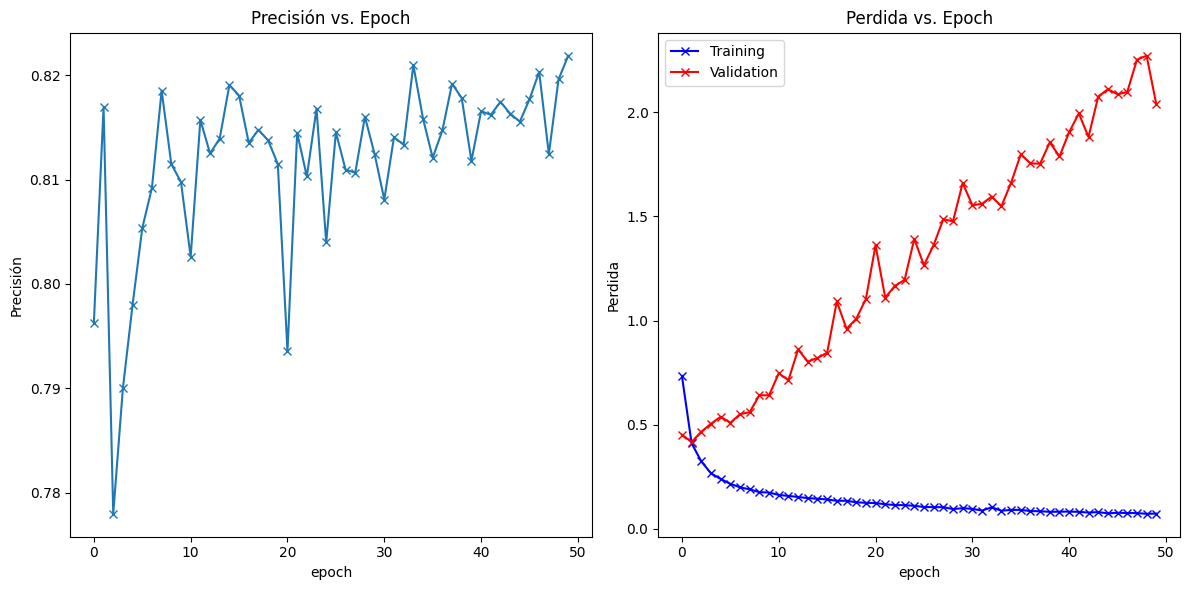

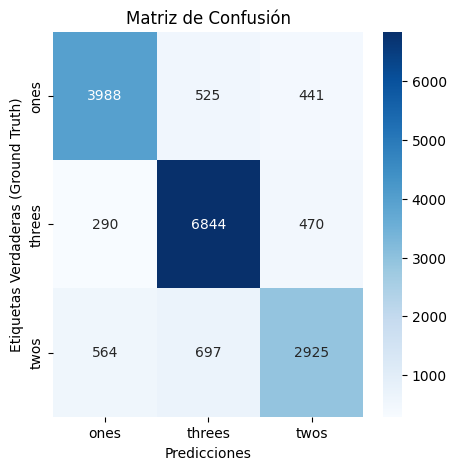

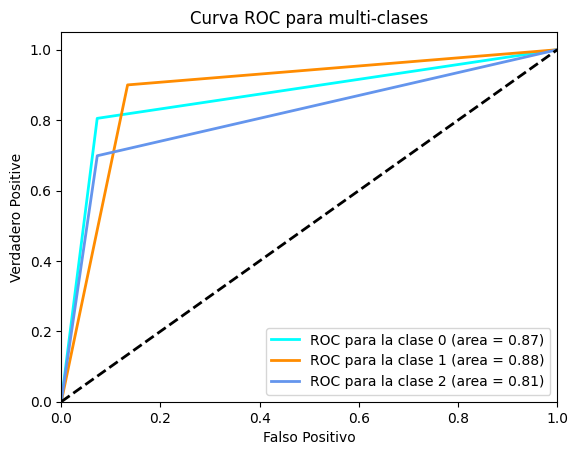

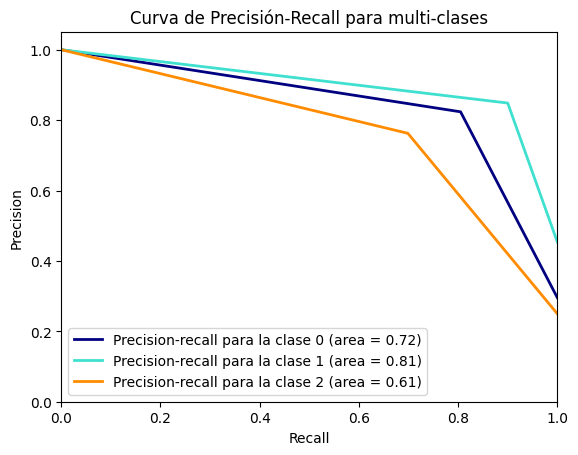

In [74]:
# Precision y Error
plot_accuracies(history)

# Matriz de confusión
plot_confusion_matrix(y_true, y_pred, train_dataset.classes)

# Curva ROC
plot_roc_curve(y_true, y_pred, n_classes=len(train_dataset.classes))

# Curva de Precisión-Recall
plot_precision_recall(y_true, y_pred, n_classes=len(train_dataset.classes))


Sensibilidad (Recall)= TP/TP+FN


Clase ones = 3988 / 3988 + 966 = 0.805

Clase twos = 2925 / 2925 + 1261 = 0.699

Clase threes = 6844 / 6844 + 760 = 0.900
​

Especificidad= TN/TN+FP


Clase ones = 10936 / 10936 + 854 = 0.927

Clase twos = 11647 / 11647 + 911 = 0.927

Clase threes = 7918 / 7918 + 1222 = 0.867

# Test del modelo con una imagen del dataset de validación

Categoria Correcta: ones , Predicción: ones


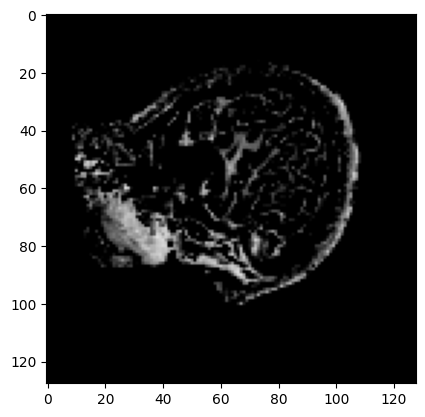

In [220]:
def test_image(img, model):
    # Convertir la imagen a un batch de un solo elemento
    xb = to_device(img.unsqueeze(0), device)
    # Obtener las predicciones del modelo
    yb = model(xb)
    # Escoger el punto de entrenamiento con la mayor probabilidad
    _, preds  = torch.max(yb, dim=1)
    return val_dataset.classes[preds[0].item()]

# Seleccionar una imagen random del dataset de validación
random = torch.randint(0, len(val_dataset), (1,)).item()
img, label = val_dataset[random]
plt.imshow(img.permute(1, 2, 0))
print('Categoria Correcta:', val_dataset.classes[label], ', Predicción:', test_image(img, model))

# Evaluacion Grad-CAM de la segunda capa convolucional

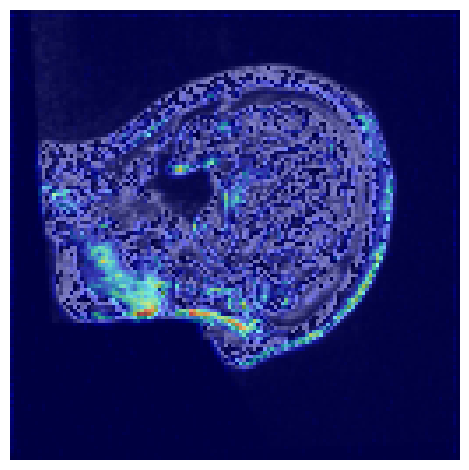

In [234]:
# Crear una instancia de GradCAM++
img = to_device(img, device)

with SmoothGradCAMpp(model, target_layer=model.conv2) as cam_extractor:
  out = model(img.unsqueeze(0))
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)


def to_pil_image(img, mode=None):
    # Convertir el tensor a imagen PIL
    return transforms.ToPILImage(mode=mode)(img.cpu().clone().detach().squeeze())

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

# Guardamos el modelo

In [42]:
torch.save(model.state_dict(), 'Custom2DCNN_v0_128_Tiny.pth')